## Data sources

In order to validate the claims from [this](https://www.bloomberg.com/news/articles/2020-05-11/why-chicken-is-plentiful-during-the-pandemic-and-beef-is-not?srnd=premium&utm_medium=social&utm_source=twitter&utm_campaign=socialflow-organic&utm_content=markets&cmpid%3D=socialflow-twitter-markets&sref=XQtHDW1P) article, I pulled price data from FRED (which sources data from the BLS) and adjusted it using the CPI. Data sources are here:

- [Poultry](https://fred.stlouisfed.org/series/APU0000706111)
- [Pork](https://fred.stlouisfed.org/series/APU0000FD3101)
- [Beef](https://fred.stlouisfed.org/series/APU0000703112)

poultry -.62
pork -.12
beef +.63

The chart below shows how the average price of 3 different types of meats has changed over time. However, these are nominal dollars, not real dollars. To adjust for the change in purchasing power of a dollar, I'll use the CPI to adjust the prices.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


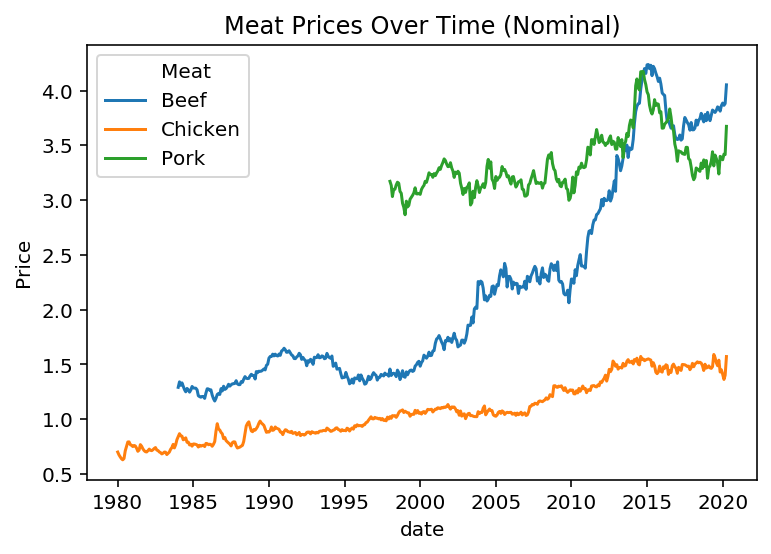

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from IPython.core.display import HTML

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# https://github.com/jupyter/notebook/issues/3670
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%run ./helpers.ipynb

cpi = get_cpi()
pcs = get_prices()

sns.lineplot(x='date', y='price', hue='Meat', data=pcs);
plt.title('Meat Prices Over Time (Nominal)')
plt.ylabel('Price');

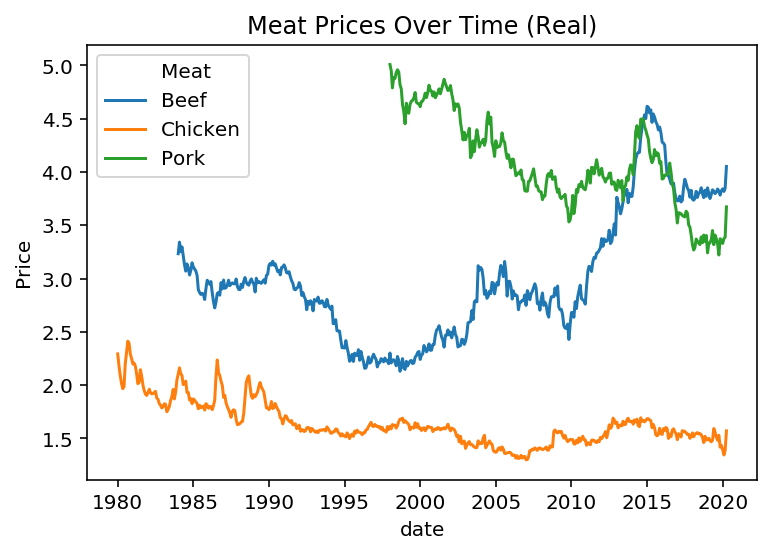

In [2]:
CURRENT_CPI = cpi.loc[cpi.date == cpi.date.max(), 'cpi'].values[0]

adjust = (
    pcs.merge(cpi, how='left', on=['date'])
    .assign(cur_price = lambda x: get_adjust(past_cpi=x.cpi,
                                             current_cpi = CURRENT_CPI,
                                             past_price = x.price))
    
);
adjust.pipe(lambda x: 
            sns.lineplot(x='date', y='cur_price', hue='Meat', data=x))

plt.ylabel('Price')
plt.title('Meat Prices Over Time (Real)');

A couple things to note here.

- Pork has certainly declined in real price
- Beef has increased in real price
- Chicken, while the nominal price has increased, the increase in dollar purchasing power outweighed that change, so chicken is less expensive than it was in the 80s.

I'll translate these results into % changes, simply by taking the pct change between the min and max dates and keep track of the start / end dates.

In [12]:
x = (
    adjust.groupby('Meat').apply(lambda x: get_diff(x, 'cur_price', 'date'))
    .reset_index()
    .drop(labels='level_1', axis=1)
    .assign(NumYears = lambda x: x['End'].dt.year - x['Start'].dt.year)
); 
HTML(
    x
    .to_html().replace('border="1"','border="0"')
)

,Meat,Change,Start,End,NumYears
0,Beef,0.253233,1984-01-01,2020-04-01,36
1,Chicken,-0.314954,1980-01-01,2020-04-01,40
2,Pork,-0.266726,1998-01-01,2020-04-01,22


The author of the article used different date ranges than I did, he found data that goes back to 1935, with is 85 years in total. I'll make a massive assumption that the price change has been consistent over each year, and I'll extrapolate backwards.

In [11]:
HTML(
    x.assign(Extrap = x.Change / x.NumYears * 85)
    .to_html().replace('border="1"','border="0"')
)

,Meat,Change,Start,End,NumYears,Extrap
0,Beef,0.253233,1984-01-01,2020-04-01,36,0.597911
1,Chicken,-0.314954,1980-01-01,2020-04-01,40,-0.669277
2,Pork,-0.266726,1998-01-01,2020-04-01,22,-1.030534


In [4]:
#HTML(df.to_html().replace('border="1"','border="0"'))